# Image preprocessing

## 1. file `train_series_description.csv` and folder `train_images`

In [1]:
import os
main_path = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification'
train_images_dir = os.listdir(f'{main_path}/train_images')

# to exclude system files like .DS_Store that are automatically created by macOS in directories.
train_images_dir = list(filter(lambda x: x.find('.DS') == -1, train_images_dir)) 
# train_images_dir = [x for x in train_images_dir if x.find('.DS') == -1]

# [train/test]_images/[study_id]/[series_id]/[instance_number].dcm 
train_images_dir[:5]  # top 5 examplar folders for study id

['1737682527', '1972129014', '2676098721', '1176954132', '3004806533']

In [2]:
import pandas as pd
train_series_descriptions = pd.read_csv(f'{main_path}/train_series_descriptions.csv')
train_series_descriptions.head(5)

study_id   series_id series_description
0   4003253   702807833   Sagittal T2/STIR
1   4003253  1054713880        Sagittal T1
2   4003253  2448190387           Axial T2
3   4646740  3201256954           Axial T2
4   4646740  3486248476        Sagittal T1

In [3]:
# distribution plotting
train_series_descriptions.groupby(by=['series_description']).size().reset_index(name='count')

series_description  count
0           Axial T2   2340
1        Sagittal T1   1980
2   Sagittal T2/STIR   1974

In [4]:
train_series_descriptions[train_series_descriptions.study_id==1972129014]

study_id   series_id series_description
2834  1972129014  2898623075   Sagittal T2/STIR
2835  1972129014  3203550406        Sagittal T1
2836  1972129014  3324327485           Axial T2

## 2. Metadata object for each study_id (all)

```
meta_obj = {
    StudyInstanceUID: {
        'folder_path': ... # path to the folder,
        'SeriesInstanceUIDs': [ Array of the SeriesInstanceUIDs ],
        'SeriesDescriptions' [ Array of the Series Descriptions ]
    }, ...
}
```

assuming that each series only has one description, i.e. 1234 series has "Axial T2"

In [5]:
# create metadata
from tqdm import tqdm

# a list of tuples like (study_id, study_id's path location)
train_images_study_id_dirs = [(int(study_id),    # integer the study_id
                               f"/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/{study_id}") 
                              for study_id in train_images_dir]

# convert the list of tuples into dictionary/metadata
metadata_object = {train_images_study_id_dir[0]: 
                       {'study_id_folder_path': train_images_study_id_dir[1], 
                        'SeriesInstanceUIDs': [],
                        'SeriesDescriptions': []}
                   for train_images_study_id_dir in train_images_study_id_dirs
                  }

# remove all the .DS files/folders (MacOS) from SeriesInstanceUIDs or series_ids folders
# then put the names for series_ids as well as the corresponding description to metadata
for study_id in tqdm(metadata_object):
    
    # SERIES_ID
    # get all series directories/folders inside each study_id directory
    series_ids_dirs = os.listdir(metadata_object[study_id]['study_id_folder_path'])
    filtered_series_ids_dirs = [int(x) for x in series_ids_dirs if x.find('.DS') == -1]   # integer(series_id)
    # put to metadata_object
    metadata_object[study_id]['SeriesInstanceUIDs'] = filtered_series_ids_dirs

    # SERIES_DESCRIPTIONS
    series_desc_df = train_series_descriptions[train_series_descriptions.study_id==study_id][["series_id", "series_description"]]
    for series_id in metadata_object[study_id]['SeriesInstanceUIDs']:
       
        series_desc_list = series_desc_df[series_desc_df.series_id==series_id].series_description.values
        
        if len(series_desc_list) == 0:
            metadata_object[study_id]['SeriesDescriptions'].append("")
        else:
            metadata_object[study_id]['SeriesDescriptions'].append(series_desc_list[0])

100%|██████████| 1975/1975 [00:08<00:00, 243.99it/s]


In [6]:
metadata_object

{1737682527: {'study_id_folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1737682527',
  'SeriesInstanceUIDs': [2291122880, 1510698437, 1258728011],
  'SeriesDescriptions': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']},
 1972129014: {'study_id_folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1972129014',
  'SeriesInstanceUIDs': [2898623075, 3324327485, 3203550406],
  'SeriesDescriptions': ['Sagittal T2/STIR', 'Axial T2', 'Sagittal T1']},
 2676098721: {'study_id_folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/2676098721',
  'SeriesInstanceUIDs': [1781977425, 1479349817, 2602311872],
  'SeriesDescriptions': ['Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']},
 1176954132: {'study_id_folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/1176954132',
  'SeriesInstanceUIDs': [195448724, 2705938708, 4025755581, 3283776646],

In [7]:
train_series_descriptions[train_series_descriptions.study_id==4003253]

study_id   series_id series_description
0   4003253   702807833   Sagittal T2/STIR
1   4003253  1054713880        Sagittal T1
2   4003253  2448190387           Axial T2

In [8]:
study_id_4003253 = metadata_object[4003253]
study_id_4003253

{'study_id_folder_path': '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4003253',
 'SeriesInstanceUIDs': [2448190387, 1054713880, 702807833],
 'SeriesDescriptions': ['Axial T2', 'Sagittal T1', 'Sagittal T2/STIR']}

## 3. Try seeing the images for `study_id = 4003253`

In [9]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt
import glob

In [10]:
def get_series_metadata(metadata_object, study_id):
    
    study_id_4003253 = metadata_object[study_id]
    
    series_images_metadata_4003253 = {}

    for idx, series_id in enumerate(study_id_4003253["SeriesInstanceUIDs"]):

        # create bases for the series_images_metadata: each series contains desc and images files
        series_images_metadata_4003253[series_id] = {'image_series_description': study_id_4003253["SeriesDescriptions"][idx], 
                                                       'image_files': []}

        # glob for patten matching as we want to get image files ending with .dcm
        study_id_folder_path = study_id_4003253["study_id_folder_path"]
        # rmb: "SeriesInstancesUIDs" is just a list of images and series_id is the actual series-id
        image_files = glob.glob(f"{study_id_folder_path}/{series_id}/*.dcm")


        # inside image_files, create a metadata for id_image and corresponding dicom readable image file
        sorted_image_files = sorted(image_files, key = lambda x: int(x.split('/')[-1].replace('.dcm', '')))

        for image_file in sorted_image_files:
            dicom_image_id = image_file.split('/')[-1].replace(".dcm", '')
            one_image_metadata = {"SOPInstanceUID": dicom_image_id,                 # id of the dicom image file 
                                  "dicom_image_file": pydicom.dcmread(image_file)}  # actual read of the dcm file

            # append this image_metadata to list of image_files
            series_images_metadata_4003253[series_id]["image_files"].append(one_image_metadata)

    return series_images_metadata_4003253
    

In [11]:
series_images_metadata_4003253 = {}

for idx, series_id in enumerate(study_id_4003253["SeriesInstanceUIDs"]):
    
    # create bases for the series_images_metadata: each series contains desc and images files
    series_images_metadata_4003253[series_id] = {'image_series_description': study_id_4003253["SeriesDescriptions"][idx], 
                                                   'image_files': []}

    # glob for patten matching as we want to get image files ending with .dcm
    study_id_folder_path = study_id_4003253["study_id_folder_path"]
    # rmb: "SeriesInstancesUIDs" is just a list of images and series_id is the actual series-id
    image_files = glob.glob(f"{study_id_folder_path}/{series_id}/*.dcm")
    
    
    # inside image_files, create a metadata for id_image and corresponding dicom readable image file
    sorted_image_files = sorted(image_files, key = lambda x: int(x.split('/')[-1].replace('.dcm', '')))
    
    for image_file in sorted_image_files:
        dicom_image_id = image_file.split('/')[-1].replace(".dcm", '')
        one_image_metadata = {"SOPInstanceUID": dicom_image_id,                 # id of the dicom image file 
                              "dicom_image_file": pydicom.dcmread(image_file)}  # actual read of the dcm file
        
        # append this image_metadata to list of image_files
        series_images_metadata_4003253[series_id]["image_files"].append(one_image_metadata)
        
series_images_metadata_4003253

{2448190387: {'image_series_description': 'Axial T2',
  'image_files': [{'SOPInstanceUID': '1',
    'dicom_image_file': Dataset.file_meta -------------------------------
    (0002, 0001) File Meta Information Version       OB: b'\x00\x01'
    (0002, 0002) Media Storage SOP Class UID         UI: Enhanced MR Image Storage
    (0002, 0003) Media Storage SOP Instance UID      UI: 4003253.1.1
    (0002, 0010) Transfer Syntax UID                 UI: RLE Lossless
    (0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
    (0002, 0013) Implementation Version Name         SH: 'PYDICOM 2.4.2'
    -------------------------------------------------
    (0008, 0018) SOP Instance UID                    UI: 4003253.1.1
    (0008, 0023) Content Date                        DA: '20240503'
    (0008, 0033) Content Time                        TM: '223716.487580'
    (0008, 103e) Series Description                  LO: 'T2'
    (0010, 0020) Patient ID                          LO: '4003253

In [12]:
# view images for this study_id = 4003253 for a particular series_description
def display_images(image_files, series_description, max_images_per_row=5):
    
    # grid for display
    num_images = len(image_files)
    num_rows = (num_images + max_images_per_row - 1) // max_images_per_row  # ceiling division (ignore the remainder, extra)
    
    # subplot grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=max_images_per_row)
    
    # flatten axes for easy looping if there are multiple rows
    if num_rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] # iterable for consistency
        
    # plot each image
    for idx, image_file in enumerate(image_files):
        ax = axes[idx]
        ax.imshow(image_file, cmap='gray') # Assuming grayscale for simplicity, change cmap as needed
        ax.axis('off')
        
    # turn off unused subplots
    for idx in range(num_images, len(axes)):
        axes[idx].axis("off")
    
    fig.suptitle(series_description, fontsize=12)
    plt.show()

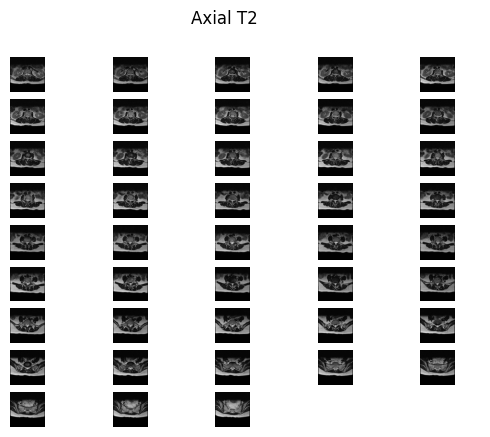

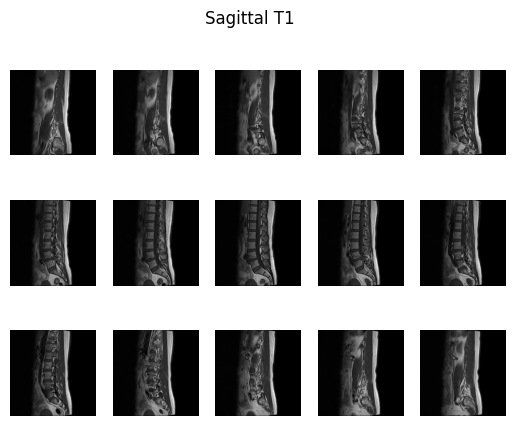

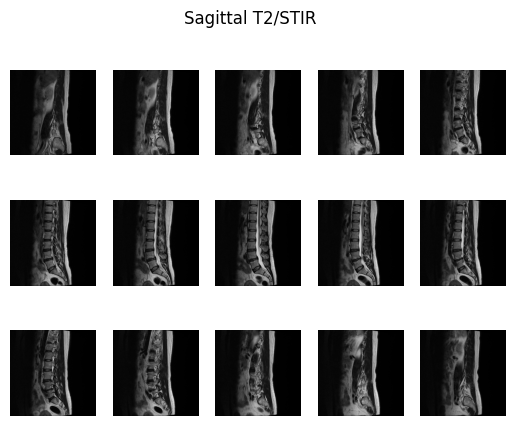

In [13]:
for series_id in series_images_metadata_4003253:
    
    series_description = series_images_metadata_4003253[series_id]["image_series_description"]
    
    # get the image_files for this particular series_id
    image_files = series_images_metadata_4003253[series_id]["image_files"]
    
    # get the dicom files to a list
    dicom_images = []
    for image_metadata in image_files:
        dicom_image = image_metadata['dicom_image_file'].pixel_array
        dicom_images.append(dicom_image)
        
    # display images for each series
    display_images(dicom_images, series_description)

## 4. Coordination of pathologies

In [14]:
coord_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
# add the columns in coordinates regarding condition+level to match with train_df

cols = ['condition', 'level']
coord_df['m_condition'] = coord_df[cols].apply(lambda row: ' '.join(row.values.astype(str)).lower(), axis=1)
coord_df['m_condition'] = coord_df['m_condition'].str.replace(r'[ /]', '_', regex=True)

train_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')

coord_df

study_id   series_id  instance_number  \
0         4003253   702807833                8   
1         4003253   702807833                8   
2         4003253   702807833                8   
3         4003253   702807833                8   
4         4003253   702807833                8   
...           ...         ...              ...   
48687  4290709089  4237840455               11   
48688  4290709089  4237840455               12   
48689  4290709089  4237840455               12   
48690  4290709089  4237840455               12   
48691  4290709089  4237840455               12   

                             condition  level           x           y  \
0                Spinal Canal Stenosis  L1/L2  322.831858  227.964602   
1                Spinal Canal Stenosis  L2/L3  320.571429  295.714286   
2                Spinal Canal Stenosis  L3/L4  323.030303  371.818182   
3                Spinal Canal Stenosis  L4/L5  335.292035  427.327434   
4                Spinal Canal Stenosis  L5/S1  353.415929  483.964602   
...                                ...    ...         ...         ...   
48687  Left Neural Foraminal Narrowing  L1/L2  219.465940   97.831063   
48688  Left Neural Foraminal Narrowing  L2/L3  205.340599  140.207084   
48689  Left Neural Foraminal Narrowing  L3/L4  202.724796  181.013624   
48690  Left Neural Foraminal Narrowing  L4/L5  202.933333  219.733333   
48691  Left Neural Foraminal Narrowing  L5/S1  211.813953  259.534884   

                                 m_condition  
0                spinal_canal_stenosis_l1_l2  
1                spinal_canal_stenosis_l2_l3  
2                spinal_canal_stenosis_l3_l4  
3                spinal_canal_stenosis_l4_l5  
4                spinal_canal_stenosis_l5_s1  
...                                      ...  
48687  left_neural_foraminal_narrowing_l1_l2  
48688  left_neural_foraminal_narrowing_l2_l3  
48689  left_neural_foraminal_narrowing_l3_l4  
48690  left_neural_foraminal_narrowing_l4_l5  
48691  left_neural_foraminal_narrowing_l5_s1  

[48692 rows x 8 columns]

In [15]:
import cv2

# this function is for one coord, one image, and one title/description/condition/level)
def display_coordinate_on_img(center_coord, image_instance_dicom, title):
    '''
    coord_entry is a particular coord for a particular image 
    image_meta is the image that specifically in the series, containing SOPInstanceUID and dicom_image_file, i.e. 
    {2448190387: {'image_series_description': 'Axial T2',
                  'image_files': [{'SOPInstanceUID': '1',
                                    'dicom_image_file': Dataset.file_meta -------------------------------
                                    (0002, 0001) File Meta Informa
    '''
    radius = 10
    color = (255, 0, 0)
    thickness = 2
    
    # for what?
    image_normalized = cv2.normalize(image_instance_dicom, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
    # circling
    image_circle = cv2.circle(image_normalized.copy(), center_coord, radius, color, thickness)
    
    # convert image from BGR to RGB for correct color display in matplotlib
    image_circle = cv2.cvtColor(image_circle, cv2.COLOR_BAYER_BG2BGR)
    
    # display
    plt.imshow(image_circle)
    plt.axis('off')
    plt.title(title)
    plt.show()

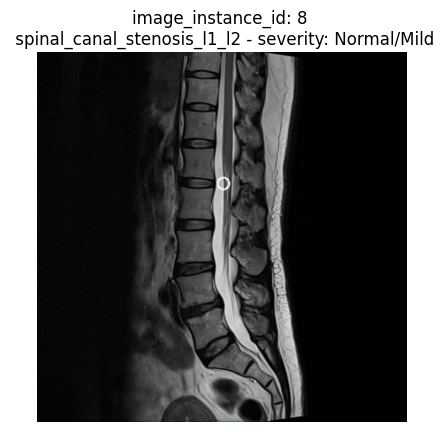

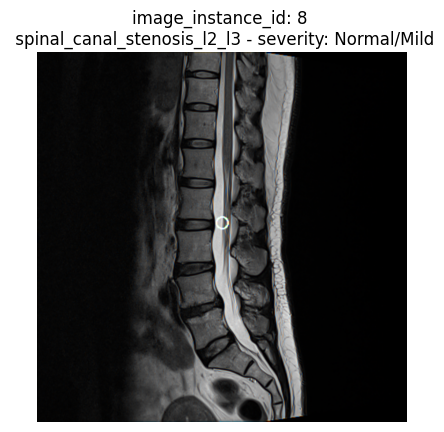

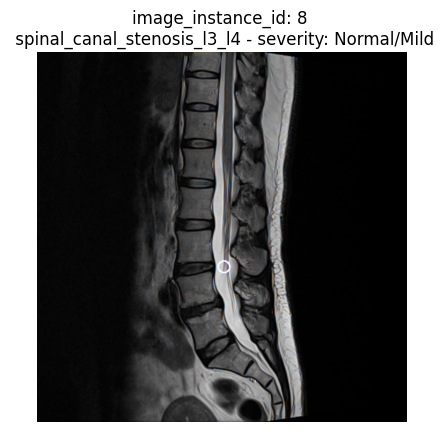

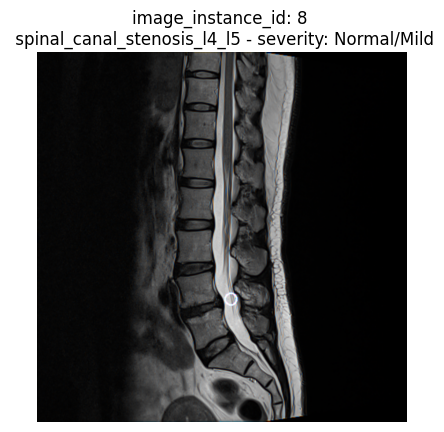

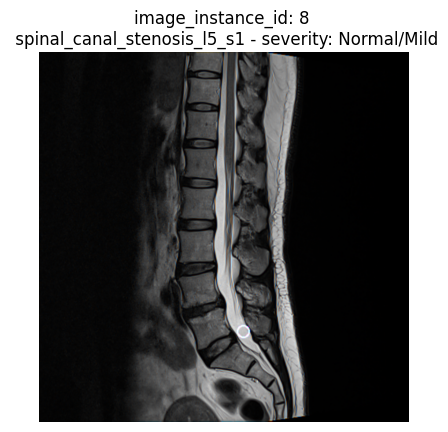

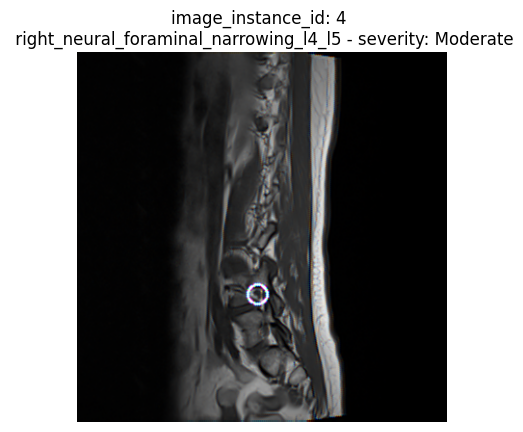

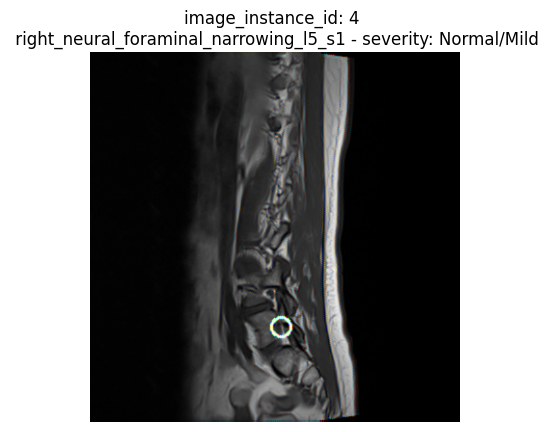

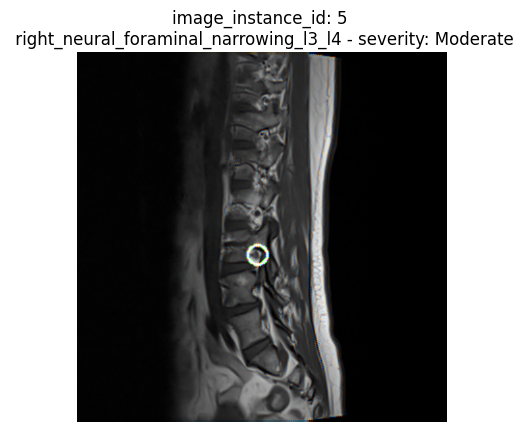

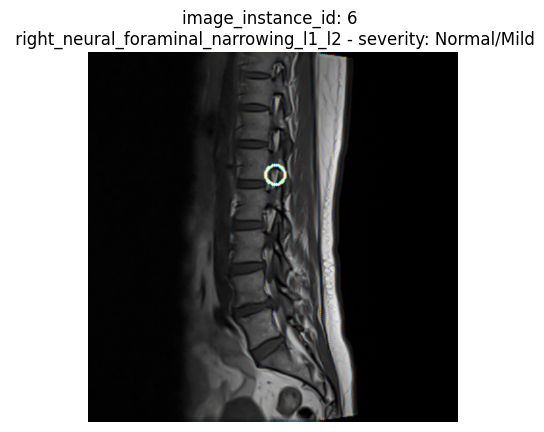

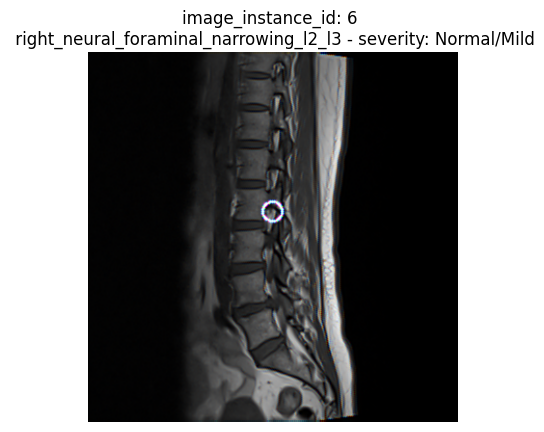

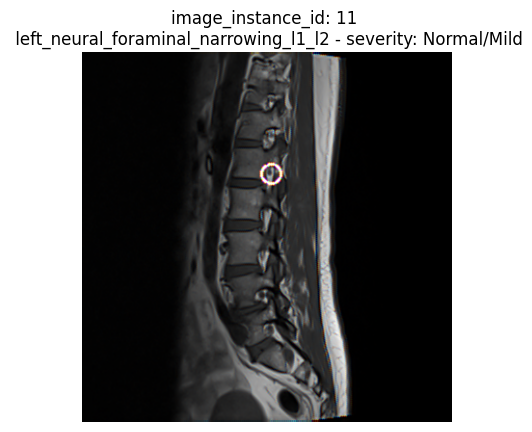

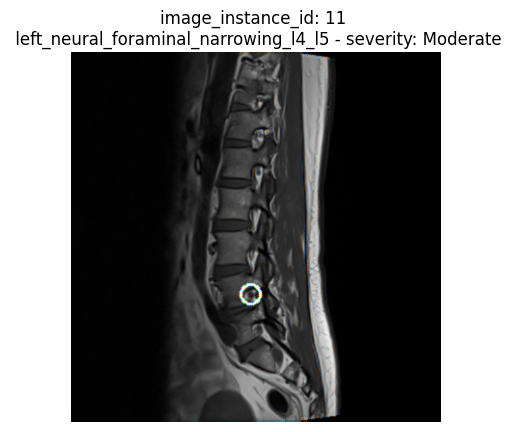

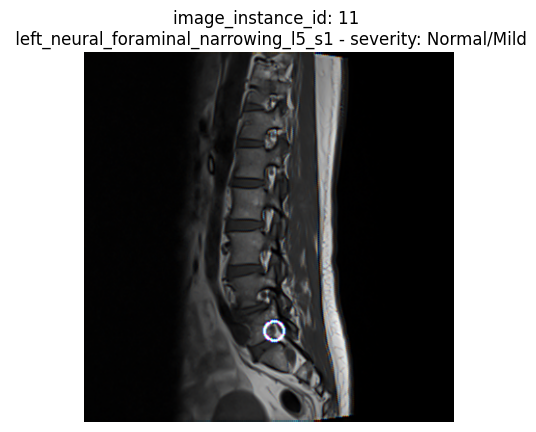

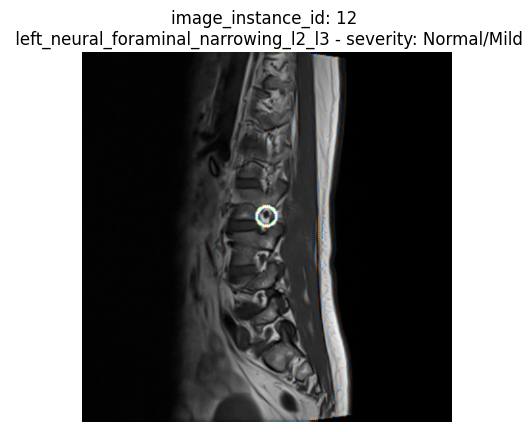

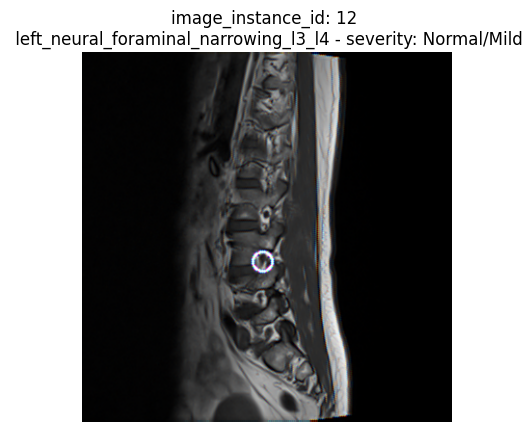

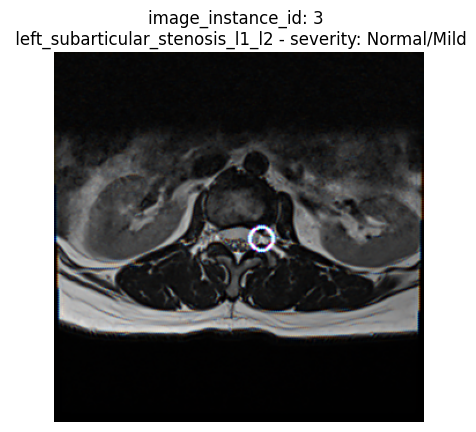

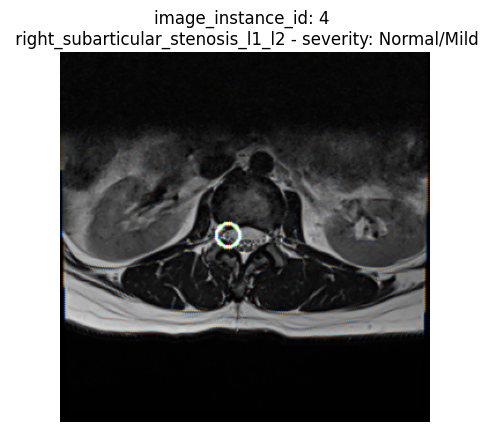

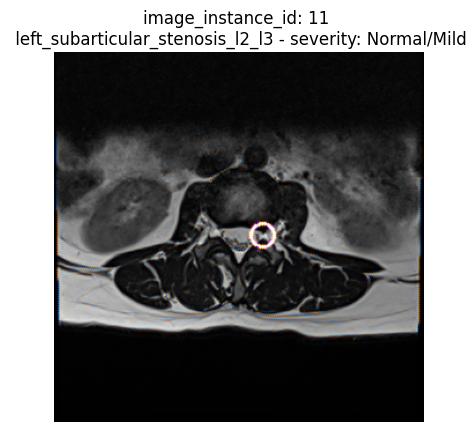

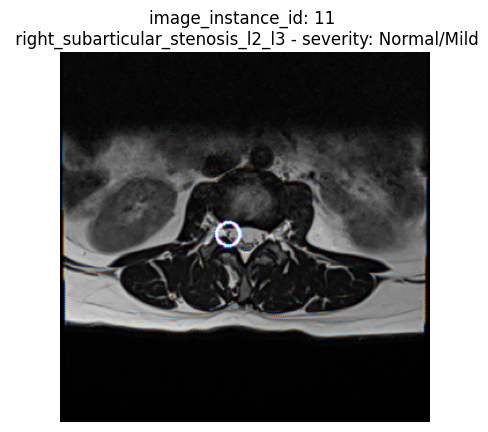

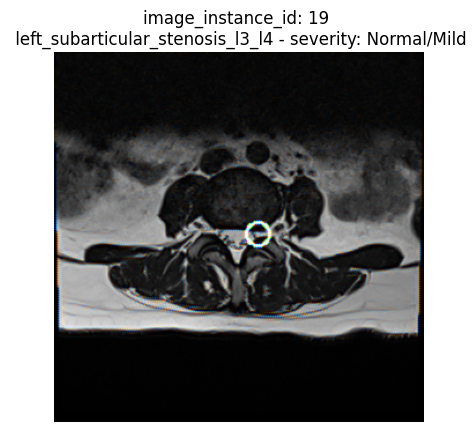

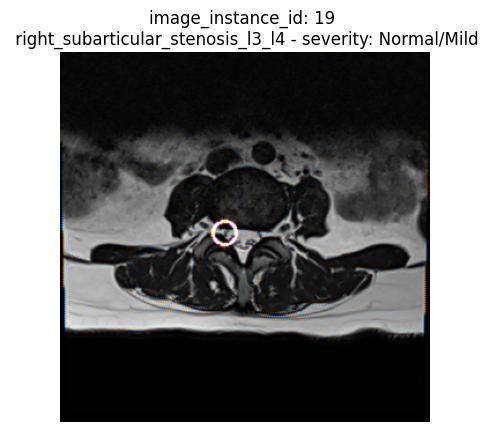

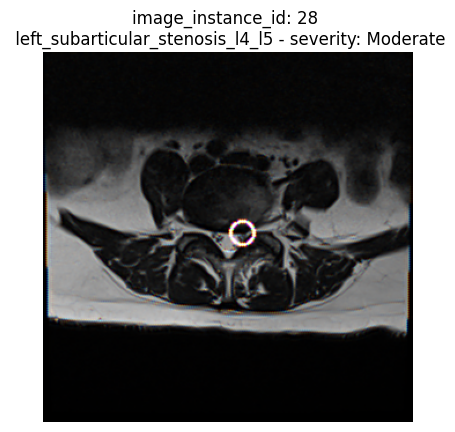

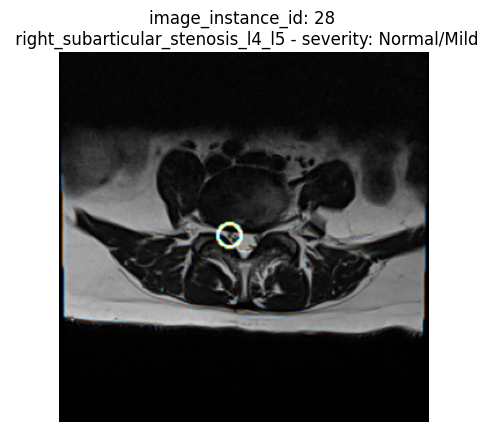

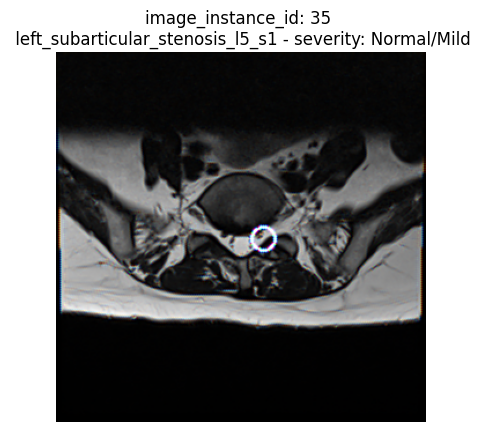

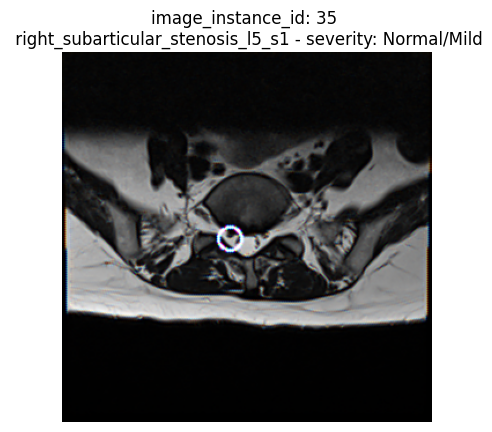

In [16]:
example_study_id = 4003253
series_meta =  get_series_metadata(metadata_object, example_study_id) # series_meta all based on given study_id
example_train_df = train_df[train_df.study_id==example_study_id]
example_coord_entries_df = coord_df[coord_df.study_id==example_study_id]

for d, coord_entry in example_coord_entries_df.iterrows():
    
    center_coord = (int(coord_entry['x']), int(coord_entry['y']))
    
    # search for the image available for coord in all imgs in series
    image_meta_instances_list = series_meta[coord_entry.series_id]["image_files"]
    # check matching
    image_instance_id = coord_entry.instance_number
    
    for image_instance in image_meta_instances_list:
        
        if int(image_instance["SOPInstanceUID"]) == int(image_instance_id):
            
            image_instance_dicom = image_instance["dicom_image_file"].pixel_array

            severity = train_df.loc[example_train_df.index[0], coord_entry.m_condition]
            title = f'image_instance_id: {image_instance_id} \n {coord_entry.m_condition} - severity: {severity}'

        
            display_coordinate_on_img(center_coord, image_instance_dicom, title)